# Figure 1.f/g : Training efficiency

Goals : 

- Show that 3D models are more efficient in terms of training data needed to reach a certain accuracy, compared to 2D models.
  
(Also shows slight advantage of 3D models in terms of accuracy, and performance of self-supervised model.)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from tifffile import imread
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import kruskal
import pyclesperanto_prototype as cle
from skimage.morphology import remove_small_objects
sys.path.append("../..")

from utils import *
from plots import *

show_params()

Plot parameters (set in plots.py) : 
- COLORMAP : ████████
- DPI : 200
- Data path : C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK
- Font size : 20
- Title font size : 25.0
- Label font size : 20.0


In [3]:
SAVE_PLOTS_AS_PNG = False
SAVE_PLOTS_AS_SVG = True

## Data loading

In [4]:
image_folder = DATA_PATH / "RESULTS/SPLITS/Analysis"
c5 = imread(image_folder / "c5.tif")
c3 = imread(image_folder / "c3.tif")
visual = imread(image_folder / "visual.tif")

gt_dict = {
    "visual": visual,
    "c3": c3,
    "c5": c5,
}

### Order data by model and split

In [5]:
def find_images(path, split):
    return list(path.glob(f"*{split}*.tif"))

In [6]:
visual_preds = {
    "Cellpose": {
        "2080": find_images(image_folder / "c1_5/cp", "2080")[0],
        "6040": find_images(image_folder / "c1_5/cp", "6040")[0],
        "8020": find_images(image_folder / "c1_5/cp", "8020")[0],
    },
    "StarDist": {
        "2080": find_images(image_folder / "c1_5/sd", "2080")[0],
        "6040": find_images(image_folder / "c1_5/sd", "6040")[0],
        "8020": find_images(image_folder / "c1_5/sd", "8020")[0],
    },
    "SegResNet": {
        "2080": find_images(image_folder / "c1_5/segres", "2080")[0],
        "6040": find_images(image_folder / "c1_5/segres", "6040")[0],
        "8020": find_images(image_folder / "c1_5/segres", "8020")[0],
    },
    "SwinUNetR": {
        "2080": find_images(image_folder / "c1_5/swin", "2080")[0],
        "6040": find_images(image_folder / "c1_5/swin", "6040")[0],
        "8020": find_images(image_folder / "c1_5/swin", "8020")[0],
    },
}
c3_preds = {
    "Cellpose": {
        "2080": find_images(image_folder / "c1245_v/cp", "2080")[0],
        "6040": find_images(image_folder / "c1245_v/cp", "6040")[0],
        "8020" : find_images(image_folder / "c1245_v/cp", "8020")[0],
    },
    "StarDist": {
        "2080": find_images(image_folder / "c1245_v/sd", "2080")[0],
        "6040": find_images(image_folder / "c1245_v/sd", "6040")[0],
        "8020": find_images(image_folder / "c1245_v/sd", "8020")[0],
    },
    "SegResNet": {
        "2080": find_images(image_folder / "c1245_v/segres", "2080")[0],
        "6040": find_images(image_folder / "c1245_v/segres", "6040")[0],
        "8020": find_images(image_folder / "c1245_v/segres", "8020")[0],
    },
    "SwinUNetR": {
        "2080": find_images(image_folder / "c1245_v/swin", "2080")[0],
        "6040": find_images(image_folder / "c1245_v/swin", "6040")[0],
        "8020": find_images(image_folder / "c1245_v/swin", "8020")[0],
    },
}
c5_preds = {
    "Cellpose": {
        "2080": find_images(image_folder / "c1-4_v/cp", "2080")[0],
        "6040": find_images(image_folder / "c1-4_v/cp", "6040")[0],
        "8020" : find_images(image_folder / "c1-4_v/cp", "8020")[0],
    },
    "StarDist": {
        "2080": find_images(image_folder / "c1-4_v/sd", "2080")[0],
        "6040": find_images(image_folder / "c1-4_v/sd", "6040")[0],
        "8020": find_images(image_folder / "c1-4_v/sd", "8020")[0],
    },
    "SegResNet": {
        "2080": find_images(image_folder / "c1-4_v/segres", "2080")[0],
        "6040": find_images(image_folder / "c1-4_v/segres", "6040")[0],
        "8020": find_images(image_folder / "c1-4_v/segres", "8020")[0],
    },
    "SwinUNetR": {
        "2080": find_images(image_folder / "c1-4_v/swin", "2080")[0],
        "6040": find_images(image_folder / "c1-4_v/swin", "6040")[0],
        "8020": find_images(image_folder / "c1-4_v/swin", "8020")[0],
    },
}


In [7]:
# organize as DataFrame
df = pd.DataFrame()
splits = [visual_preds, c3_preds, c5_preds]
for i, gt_name in enumerate(gt_dict):
    preds = splits[i]
    for model_name in preds:
        for split in preds[model_name]:
            gt = gt_dict[gt_name]
            df = pd.concat([df, pd.DataFrame({
                "model": model_name,
                "split": split[:2] + "/" + split[2:],
                "gt": gt_name,
                "path": [preds[model_name][split]],
            })])
df.reset_index(inplace=True, drop=True)
df

,model,split,gt,path
0,Cellpose,20/80,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
1,Cellpose,60/40,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
2,Cellpose,80/20,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
3,StarDist,20/80,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
4,StarDist,60/40,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
5,StarDist,80/20,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
6,SegResNet,20/80,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
7,SegResNet,60/40,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
8,SegResNet,80/20,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
9,SwinUNetR,20/80,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...


In [8]:
df.iloc[0].path

WindowsPath('C:/Users/Cyril/Desktop/Code/CELLSEG_BENCHMARK/RESULTS/SPLITS/Analysis/c1_5/cp/cellpose_2080_labels.tif')

In [9]:
df.loc[len(df)] = ["WNet3D", "WNet - Artifacts", "visual", image_folder / "WNet/visual_pred.tif"]
df.loc[len(df)] = ["WNet3D", "WNet - Artifacts", "c3", image_folder / "WNet/c3_pred.tif"]
df.loc[len(df)] = ["WNet3D", "WNet - Artifacts", "c5", image_folder / "WNet/c5_pred.tif"]
df

,model,split,gt,path
0,Cellpose,20/80,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
1,Cellpose,60/40,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
2,Cellpose,80/20,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
3,StarDist,20/80,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
4,StarDist,60/40,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
5,StarDist,80/20,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
6,SegResNet,20/80,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
7,SegResNet,60/40,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
8,SegResNet,80/20,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
9,SwinUNetR,20/80,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...


In [10]:
model_names = ["StarDist", "Cellpose", "SegResNet", "SwinUNetR", "WNet3D"]

```{note}
For WNet3D, we compute two sets of Dices :

- One on c3, c5 and ALL of visual, which contains some artifacts. This is "All data".
- One on c3, c5 and PART of visual, which does not contain artifacts. This is "No artifacts".

In [11]:
visual_slice = 50
visual_gt_no_artifact = gt_dict["visual"][:visual_slice,:,:]
wnet_c3_pred = imread(image_folder / "WNet/c3_pred.tif")
wnet_c5_pred = imread(image_folder / "WNet/c5_pred.tif")
wnet_visual_no_artifact = imread(image_folder / "WNet/visual_pred.tif")[:visual_slice,:,:]

## Dice computation

### Pre-processing for SwinUNetR and SegResNet

In [12]:
# We use the same threshold for all splits, estimated from the training data from the supervised benchmark figure 
swin_params = {
    "20/80": {
        "thresh": 0.4,
        "spot_sigma": 0.65,
        "outline_sigma": 0.65,
    },
    "60/40": {
        "thresh": 0.4,
        "spot_sigma": 0.65,
        "outline_sigma": 0.65,
    },
    "80/20": {
        "thresh": 0.4,
        "spot_sigma": 0.65,
        "outline_sigma": 0.65,
    }
}
segres_params = {
    "20/80": {
        "thresh": 0.3,
        "spot_sigma": 0.65,
        "outline_sigma": 0.65,
    },
    "60/40": {
        "thresh": 0.3,
        "spot_sigma": 0.65,
        "outline_sigma": 0.65,
    },
    "80/20": {
        "thresh": 0.3,
        "spot_sigma": 0.65,
        "outline_sigma": 0.65,
    }
}

def models_instance_preprocessing(volume, params, split):
    params = params[split]
    volume = np.where(volume > params["thresh"], volume, 0)
    labels = cle.voronoi_otsu_labeling(volume, spot_sigma=params["spot_sigma"], outline_sigma=params["outline_sigma"])
    labels = remove_small_objects(np.array(labels), min_size=5)
    return labels

In [13]:
# import napari
# viewer = napari.Viewer()
# # show visual gt and swin preprocessed for each split
# swin_path = df.iloc[9]
# swin_pred = imread(swin_path.path)
# viewer.add_labels(gt_dict["c3"], name="c3_gt")
# swin_pred_processed = models_instance_preprocessing(swin_pred, swin_params)
# viewer.add_labels(swin_pred_processed, name="swin_pred")
# viewer.add_image(np.swapaxes(swin_pred), name="swin_pred_raw", colormap="turbo")

In [14]:
df.set_index(["model", "split"], inplace=True)

In [15]:
def model_dices_across_splits(df, verbose=False):
    dices_df = pd.DataFrame(columns=["Dice", "Model", "Split"])
    for model in model_names:
        for split in df.loc[model].index:
            for i, row in df.loc[model].loc[split].iterrows():
                gt = gt_dict[row["gt"]]
                pred = imread(row.path)
                if model == "SwinUNetR":
                    pred = models_instance_preprocessing(pred, swin_params, split)
                if model == "SegResNet":
                    pred = models_instance_preprocessing(pred, segres_params, split)
                gt = np.where(gt > 0, 1, 0)
                pred = np.where(pred > 0, 1, 0)
                dice = dice_coeff(gt, pred)
                if verbose:
                    print(f"Model: {model}, Split: {split}, GT: {row['gt']}")
                    print(f"Image shape: {pred.shape}")
                    print(f"GT shape: {gt_dict[row['gt']].shape}")
                    print(f"Dice: {dice}")
                    print("_"*20)
                dices_df.loc[len(dices_df)] = [dice, model, split]
    return dices_df

In [16]:
dices_df = model_dices_across_splits(df, verbose=False)

In [17]:
dices_df

,Dice,Model,Split
0,0.690006,StarDist,20/80
1,0.000017,StarDist,20/80
2,0.000024,StarDist,20/80
3,0.649160,StarDist,60/40
4,0.521939,StarDist,60/40
...,...,...,...
112,0.811354,WNet3D,WNet - Artifacts
113,0.808755,WNet3D,WNet - Artifacts
114,0.589656,WNet3D,WNet - Artifacts
115,0.811354,WNet3D,WNet - Artifacts


### WNet3D - No artifacts

In [18]:
wnet_preds_no_artifacts = { # No artifacts
    "WNet3D - No artifacts": {
        "visual": wnet_visual_no_artifact,
        "c3": wnet_c3_pred,
        "c5": wnet_c5_pred,
    }
}
gt_dict_no_artifacts = {
    "visual": visual_gt_no_artifact,
    "c3": c3,
    "c5": c5,
}
for split in wnet_preds_no_artifacts:
    for image in wnet_preds_no_artifacts[split]:
        gt = gt_dict_no_artifacts[image]
        pred = wnet_preds_no_artifacts[split][image]
        gt = np.where(gt > 0, 1, 0)
        pred = np.where(pred > 0, 1, 0)
        dice = dice_coeff(gt, pred)
        print(f"Split: {split}, Image: {image}, Dice: {dice}")
        dices_df.loc[len(dices_df)] = [dice, "WNet3D", split]

Split: WNet3D - No artifacts, Image: visual, Dice: 0.8179572126452918
Split: WNet3D - No artifacts, Image: c3, Dice: 0.8113536341409202
Split: WNet3D - No artifacts, Image: c5, Dice: 0.8087545264446371


### Detailed stats 
Shows means and stds of select splits for manuscript.

In [19]:
dice_df_8020 = dices_df[dices_df["Split"] == "80/20"]
dice_df_8020.groupby("Model", sort=False).agg({"Dice": ["mean", "std"]})

Dice          
               mean       std
Model                        
StarDist   0.605878  0.063935
Cellpose   0.760962  0.030298
SegResNet  0.735171  0.056445
SwinUNetR  0.829909  0.008376

In [20]:
dice_df_wnet = dices_df[dices_df["Model"] == "WNet3D"]
dice_df_wnet.groupby("Split").agg({"Dice": ["mean", "std"]})

Dice          
                           mean       std
Split                                    
WNet - Artifacts       0.736588  0.110205
WNet3D - No artifacts  0.812688  0.004744

## Plots

In [21]:
dices_df['Model_Split'] = dices_df['Model'] + ' (' + dices_df['Split'].astype(str) + ')'

Due to the way seaborn boxplots interact with categories, the axes will be generated for all models/splits, and then separate boxplots are used to have readable boxes for each model.

The data is the same everywhere, this is only to have cleaner figures.

In addition, since SwinUNetR and WNet have much smaller variance, we show a zoomed-in inset for these models.

### General plot

C:\Users\Cyril\AppData\Local\Temp\ipykernel_22568\2494682398.py:2: UserWarning: The palette list has more values (16) than needed (14), which may not be intended.
  sns.boxplot(


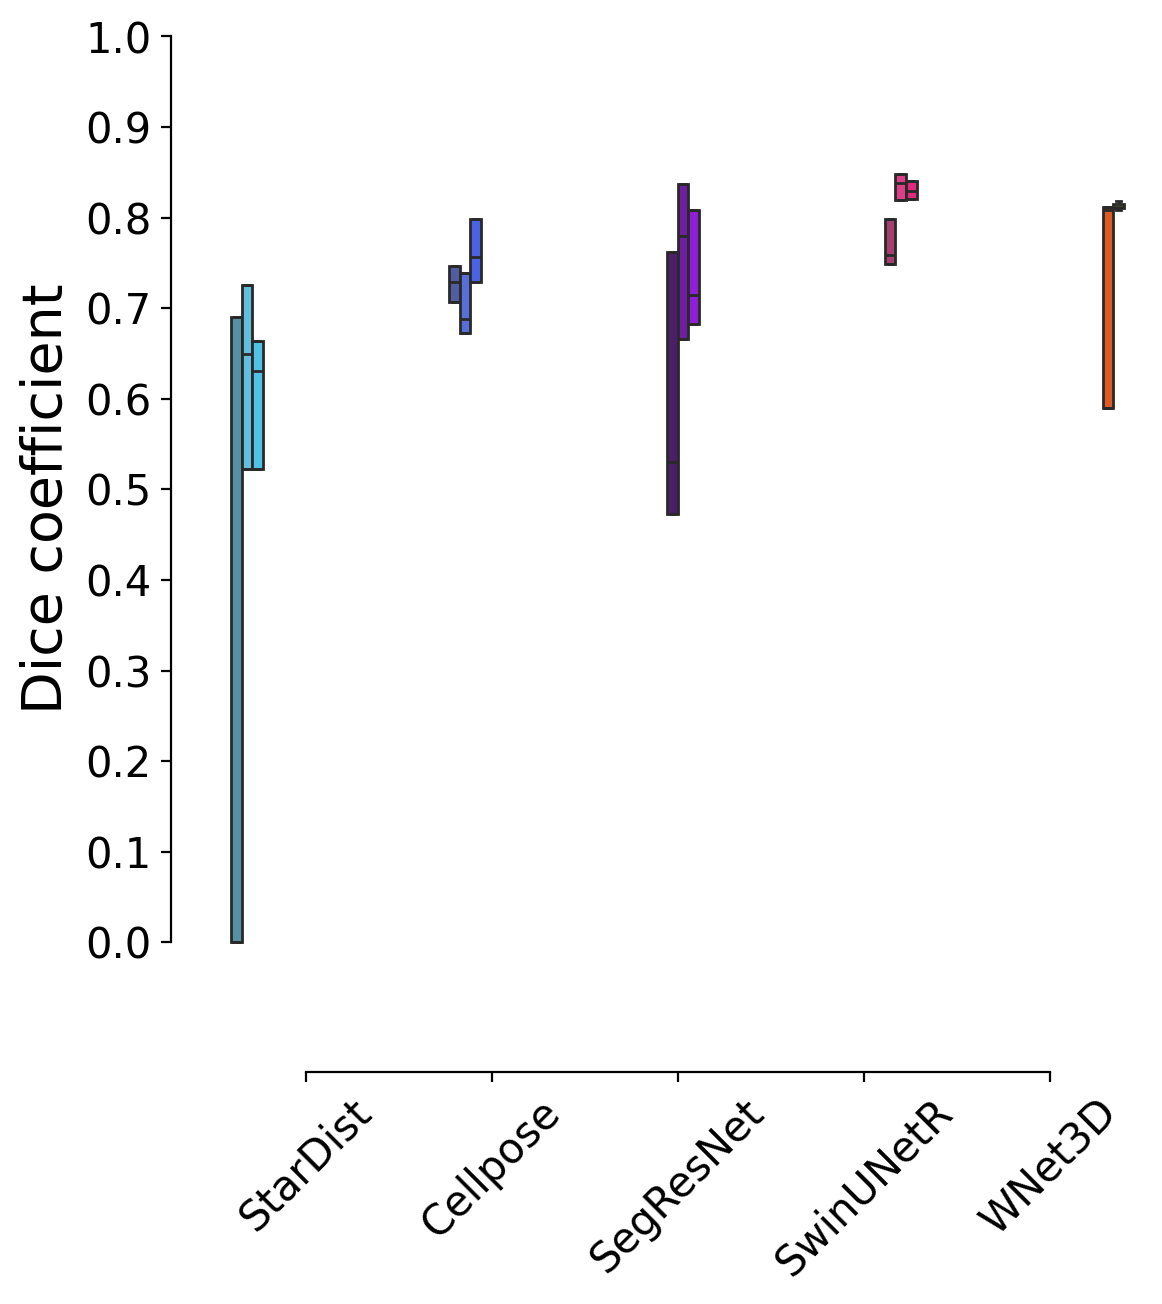

In [22]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=DPI)
sns.boxplot(
    data=dices_df,
    x="Model", 
    y="Dice", 
    hue="Model_Split", 
    ax=ax, 
    palette=EXPANDED_COLORMAP,
    # dodge=False,
    )
for i, artist in enumerate(ax.artists): # try to center the boxplot on xticks
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(artist.get_facecolor())
        if j % 6 == 4: 
            x, y = line.get_xydata()[0]
            x_center = i // 2 
            if i % 2: 
                line.set_xdata([x_center + 0.2, x_center + 0.2, x, x_center + 0.2])
            else:  
                line.set_xdata([x_center - 0.2, x_center - 0.2, x, x_center - 0.2])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis="both", which="major", labelsize=LEGEND_FONT_SIZE)
ax.tick_params(axis = 'x',   rotation = 45)
plt.ylim([-0.02,1])
ax.set_yticks(np.arange(0,1.1,0.1))
sns.despine(
    left=False,
    right=True,
    bottom=False,
    top=True,
    trim=True,
    offset={"bottom": 40, "left": 15},
)
legend = ax.legend(fontsize=LEGEND_FONT_SIZE, bbox_to_anchor=BBOX_TO_ANCHOR, loc=LOC)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
legend.get_frame().set_alpha(0)
ax.set_xlabel("", fontsize=LABEL_FONT_SIZE)
ax.set_ylabel("Dice coefficient", fontsize=LABEL_FONT_SIZE)
plt.legend([],[], frameon=False)
plt.show()

if SAVE_PLOTS_AS_PNG:
    fig.savefig("Label_efficiency.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    fig.savefig("Label_efficiency.svg", bbox_inches="tight")

### Legend

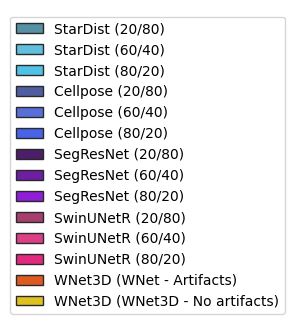

In [23]:
fig_leg = plt.figure(figsize=(3, 2))
ax_leg = fig_leg.add_subplot(111)
ax_leg.legend(handles=legend.legend_handles, labels=[text.get_text() for text in legend.texts])
ax_leg.axis('off')
plt.show()
if SAVE_PLOTS_AS_PNG:
    fig_leg.savefig("Label_efficiency_legend.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    fig_leg.savefig("Label_efficiency_legend.svg", bbox_inches="tight")

### Boxplots for each model

StarDist


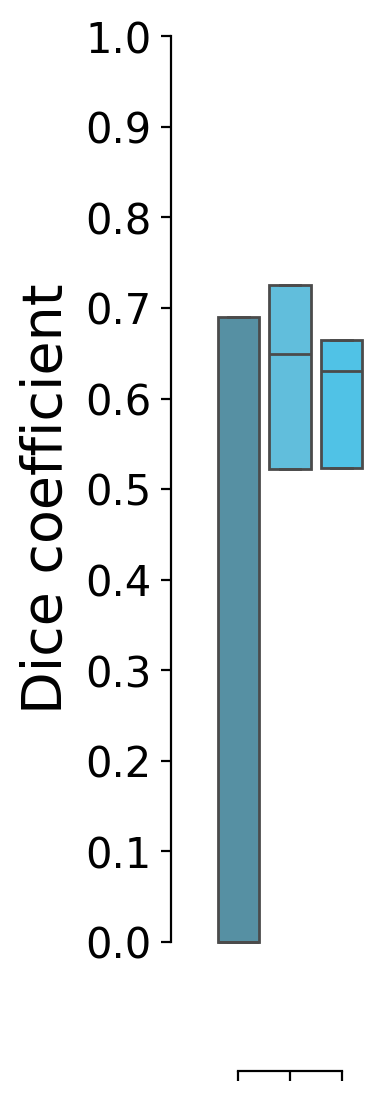

Cellpose


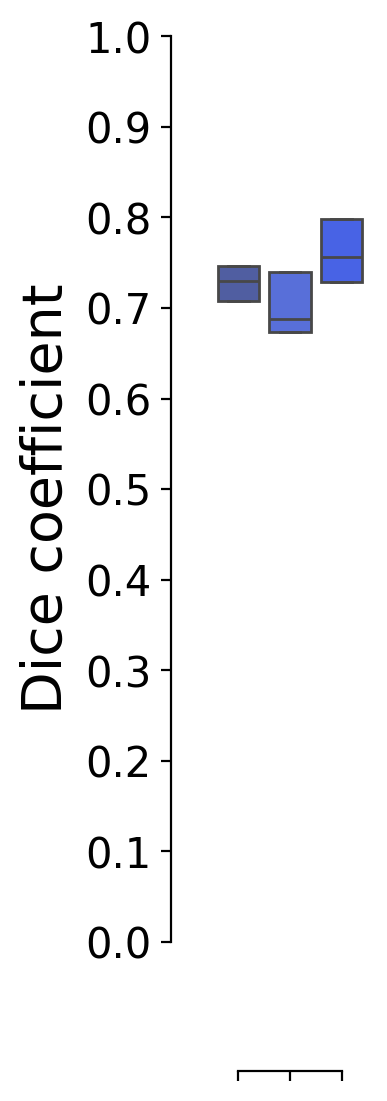

SegResNet


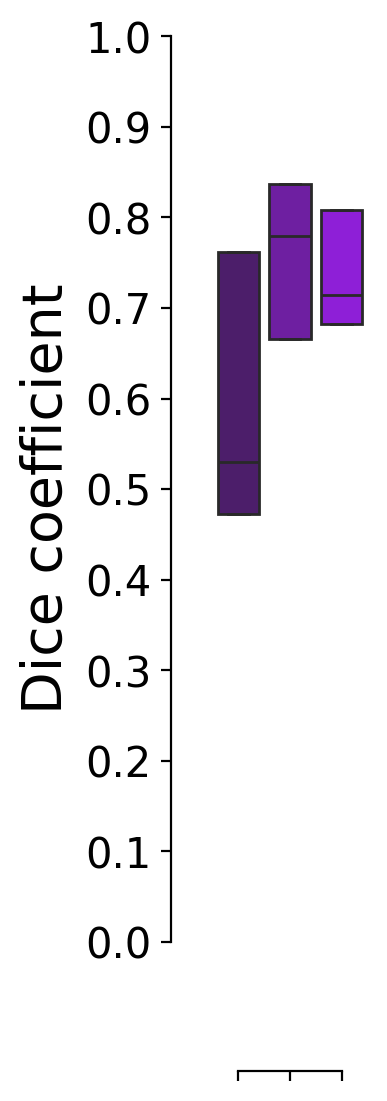

SwinUNetR


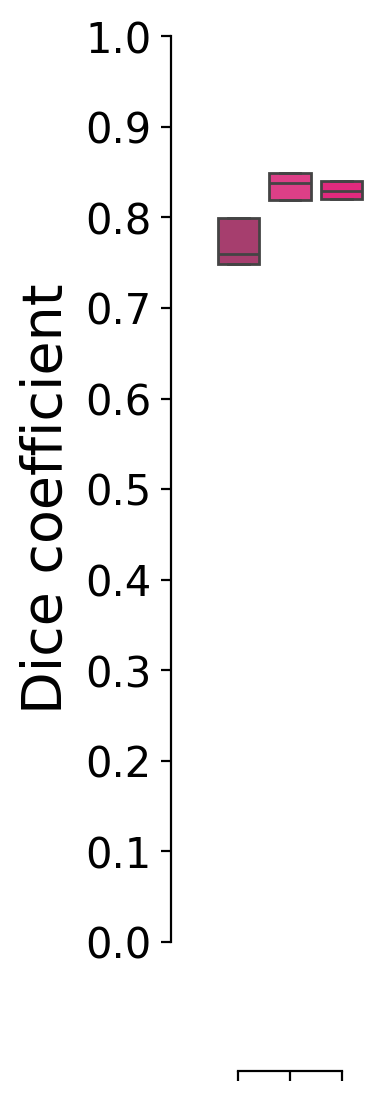

WNet3D


C:\Users\Cyril\AppData\Local\Temp\ipykernel_22568\2749076245.py:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(


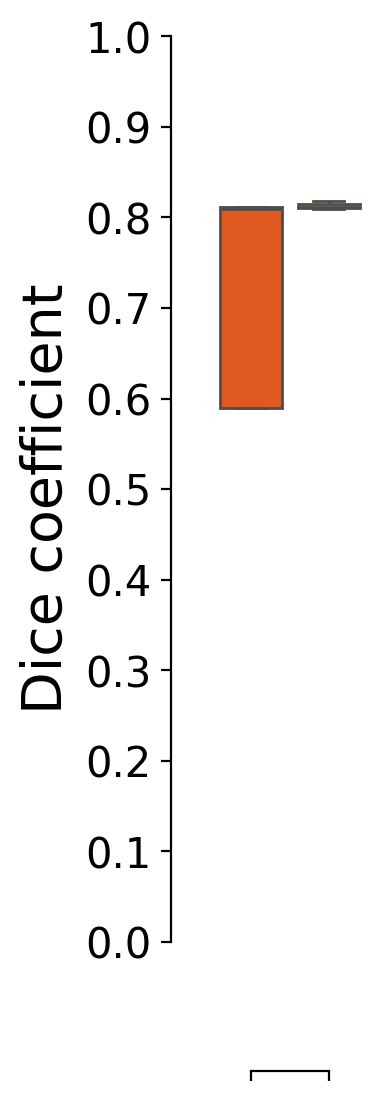

In [24]:
models_dfs = [dices_df[dices_df["Model"] == model].copy() for model in model_names]
save_path = Path("label_efficiency")
save_path.mkdir(exist_ok=True)
for i, model in enumerate(model_names):
    print(model)
    # figsize_width = 1 if model != "WNet - Ours" else 0.33 # does not accept float values
    fig, ax = plt.subplots(figsize=(1, 6), dpi=DPI)
    df = models_dfs[i]
    sns.boxplot(
        data=df,
        x="Model_Split", 
        y="Dice", 
        hue="Split", 
        ax=ax, 
        palette=EXPANDED_COLORMAP[0+3*i:3+3*i],
    )
    ax.tick_params(axis = 'x',   rotation = 45)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis="both", which="major", labelsize=LEGEND_FONT_SIZE)
    ax.set_yticks(np.arange(0,1.1,0.1))
    ax.set_ylim([-0.02,1])
    sns.despine(
        left=False,
        right=True,
        bottom=False,
        top=True,
        trim=True,
        offset={"bottom": 40, "left": 15},
        ax=ax
    )
    ax.set_xticklabels("", fontsize=LABEL_FONT_SIZE)
    ax.set_xlabel("", fontsize=LABEL_FONT_SIZE)
    ax.set_ylabel("Dice coefficient", fontsize=LABEL_FONT_SIZE)
    ax.legend([],[], frameon=False)
    ax.patch.set_alpha(0)
    legend = ax.get_legend()
    if legend:
        legend.remove()
    # ax.set_title(model, fontsize=LABEL_FONT_SIZE)
    plt.show()
    if SAVE_PLOTS_AS_PNG:
        fig.savefig(f"{str(save_path)}/Label_efficiency_{model}.png", dpi=DPI, bbox_inches="tight")
    if SAVE_PLOTS_AS_SVG:
        fig.savefig(f"{str(save_path)}/Label_efficiency_{model}.svg", bbox_inches="tight")

### Zoom-in for rightmost models

C:\Users\Cyril\AppData\Local\Temp\ipykernel_22568\2973895916.py:4: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.boxplot(data=zoom_dices_df, x="Model", y="Dice", hue="Split", ax=ax, palette=EXPANDED_COLORMAP[9:], dodge=True)


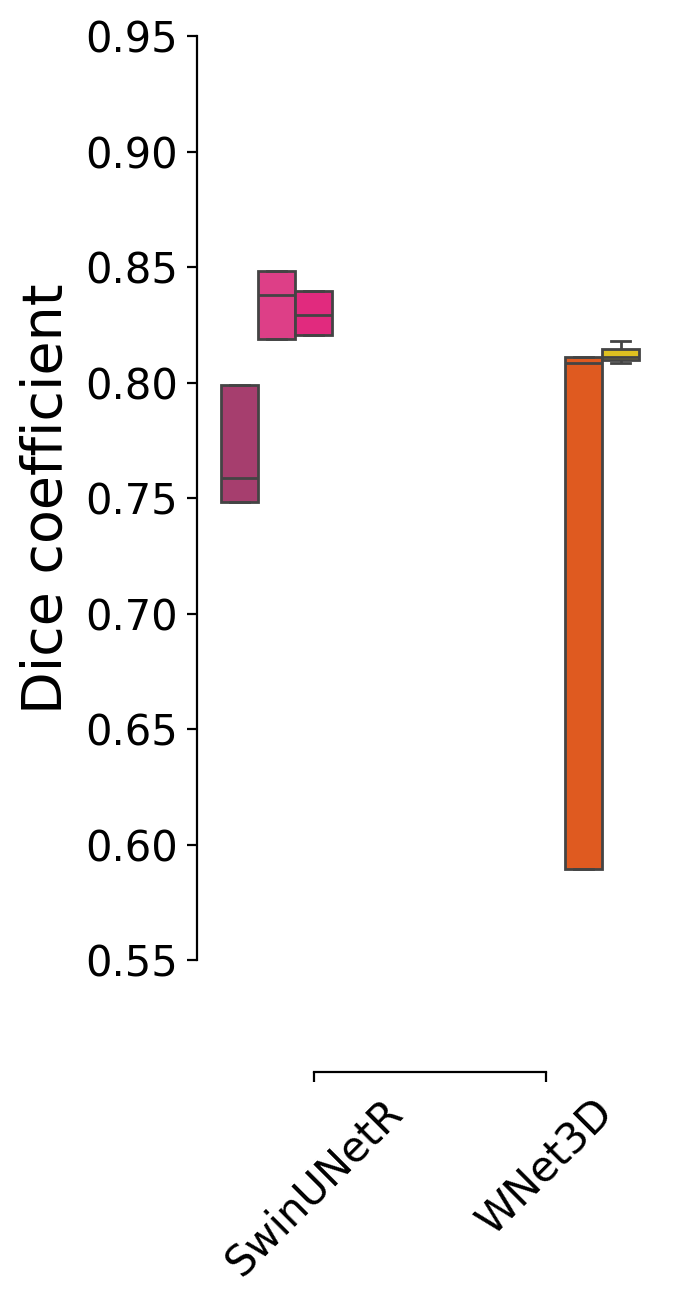

In [25]:
# same as above with Swin and WNet and y axis on the right
fig, ax = plt.subplots(figsize=(3, 6), dpi=DPI)
zoom_dices_df = dices_df[dices_df["Model"].isin(["SwinUNetR", "WNet3D"])]
sns.boxplot(data=zoom_dices_df, x="Model", y="Dice", hue="Split", ax=ax, palette=EXPANDED_COLORMAP[9:], dodge=True)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis="both", which="major", labelsize=LEGEND_FONT_SIZE)
ax.tick_params(axis = 'x',   rotation = 45,)
# ax.set_ylim([0.8,0.85])
# ax.set_yticks(np.arange(0.8,0.86,0.01))
ax.set_ylim([0.55,0.95])
ax.set_yticks(np.arange(0.55,0.96,0.05))
ax.set_xlabel("", fontsize=LABEL_FONT_SIZE)
ax.set_ylabel("Dice coefficient", fontsize=LABEL_FONT_SIZE)
ax.legend_.remove()
sns.despine(
    left=False,
    right=True,
    bottom=False,
    top=True,
    trim=True,
    offset={"bottom": 40, "right": 15},
)
# legend = ax.legend(fontsize=LEGEND_FONT_SIZE, bbox_to_anchor=BBOX_TO_ANCHOR, loc=LOC)
# legend.get_frame().set_alpha(0)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

if SAVE_PLOTS_AS_PNG:
    fig.savefig("Label_efficiency_SWIN_WNET_zoom.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    fig.savefig("Label_efficiency_SWIN_WNET_zoom.svg", bbox_inches="tight")

## Statistical tests

Here we run a Kruskal-Wallis test to assess if all models differ from each other, when performance is averaged across splits. 

### Performance across models


In [32]:
dices_df

,Dice,Model,Split,Model_Split
0,0.690006,StarDist,20/80,StarDist (20/80)
1,0.000017,StarDist,20/80,StarDist (20/80)
2,0.000024,StarDist,20/80,StarDist (20/80)
3,0.649160,StarDist,60/40,StarDist (60/40)
4,0.521939,StarDist,60/40,StarDist (60/40)
...,...,...,...,...
106,0.839906,SwinUNetR,80/20,SwinUNetR (80/20)
107,0.820599,SwinUNetR,80/20,SwinUNetR (80/20)
117,0.817957,WNet3D,WNet3D - No artifacts,WNet3D (WNet3D - No artifacts)
118,0.811354,WNet3D,WNet3D - No artifacts,WNet3D (WNet3D - No artifacts)


C:\Users\Cyril\AppData\Local\Temp\ipykernel_22568\2632306255.py:3: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.boxplot(data=dices_df, hue="Model", y="Dice", palette=COLORMAP)


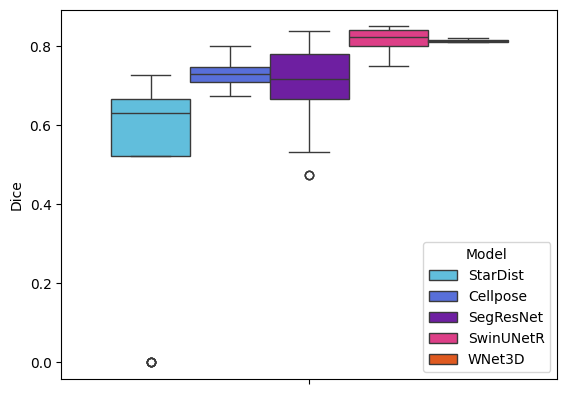

In [27]:
test_df = dices_df[dices_df["Split"] != "WNet - Artifacts"]
test_df = test_df.groupby("Model", sort=False).Dice.apply(list).reset_index()
sns.boxplot(data=dices_df, hue="Model", y="Dice", palette=COLORMAP)
plt.show()

In [28]:
print(kruskal(*test_df.Dice.tolist()))

KruskalResult(statistic=68.00628687833664, pvalue=5.980389698141091e-14)


<Axes: >

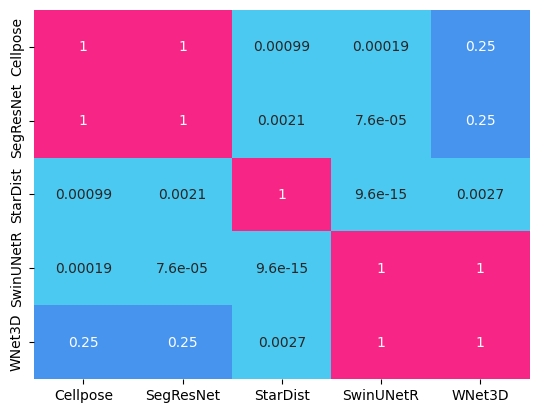

In [33]:
from scikit_posthocs import posthoc_dunn
results = posthoc_dunn(dices_df, val_col="Dice", group_col="Model", p_adjust="holm")
sns.heatmap(results, annot=True, cmap=SEQUENTIAL_COLORMAP, cbar=False)
if SAVE_PLOTS_AS_PNG:
    plt.savefig("Label_efficiency_posthoc.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("Label_efficiency_posthoc.svg", bbox_inches="tight")